In [1]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


# load and prepare data
identical to 04_02_eda_user_behavior

"df_user_sessions" contains the prepared data for further analysis

In [8]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"
USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"
LATE_FLAG_COL = "Verspätet"
MEDIA_TYPE_COL = "Medientyp"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")

# --- analyze learning effect over time ---
df_user_sessions = borrowings.copy()

# define a borrowing "session" as same user + same issue timestamp
df_user_sessions["issue_session"] = df_user_sessions[ISSUE_COL].dt.floor("D")  # change to ISSUE_COL

# ngroup is global; convert to per-user consecutive numbering
df_user_sessions["session_index"] = (
    df_user_sessions
    .groupby(USER_ID_COL)["issue_session"]
    .transform(lambda s: pd.factorize(s, sort=True)[0] + 1)
)

## Analysis of media Type loan behavior

First we look at the basic properties of user sessions and the media types involved
The maximum amount of session is limited at 50 to eliminate outliers.

In [11]:
K = 50

df = (
    df_user_sessions
    .dropna(subset=[USER_ID_COL, "issue_session", "session_index"])
            .loc[lambda d: d["session_index"].between(1, K)]
            .copy()
            )

df_sessions = (
    df.groupby([USER_ID_COL, "issue_session", "session_index"], as_index=False)
    .agg(
        n_items=(MEDIA_TYPE_COL, "size"),
        n_media_types=(MEDIA_TYPE_COL, "nunique"),
    )
)

df_session_index_table = (
    df_sessions
    .groupby("session_index", as_index=False)
    .agg(
        n_sessions=("session_index", "size"),

        mean_items=("n_items", "mean"),
        median_items=("n_items", "median"),
        p90_items=("n_items", lambda s: np.percentile(s, 90)),
        max_items=("n_items", "max"),

        mean_media_types=("n_media_types", "mean"),
        median_media_types=("n_media_types", "median"),
        p90_media_types=("n_media_types", lambda s: np.percentile(s, 90)),
        max_media_types=("n_media_types", "max"),
    )
    .sort_values("session_index")
    .reset_index(drop=True)
)

df_session_index_table.head()


,session_index,n_sessions,mean_items,median_items,p90_items,max_items,mean_media_types,median_media_types,p90_media_types,max_media_types
0,1.0000,20753,3.8575,3.0000,8.0000,49,1.4360,1.0000,2.0000,8
1,2.0000,17571,3.8682,3.0000,8.0000,42,1.4264,1.0000,2.0000,6
2,3.0000,15565,3.9911,3.0000,9.0000,51,1.4355,1.0000,2.0000,7
3,4.0000,14129,4.0809,3.0000,9.0000,40,1.4547,1.0000,2.0000,7
4,5.0000,12935,4.1681,3.0000,9.0000,45,1.4628,1.0000,2.0000,8


For a better visualization we can see the following plot

/tmp/ipykernel_166525/2742499862.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


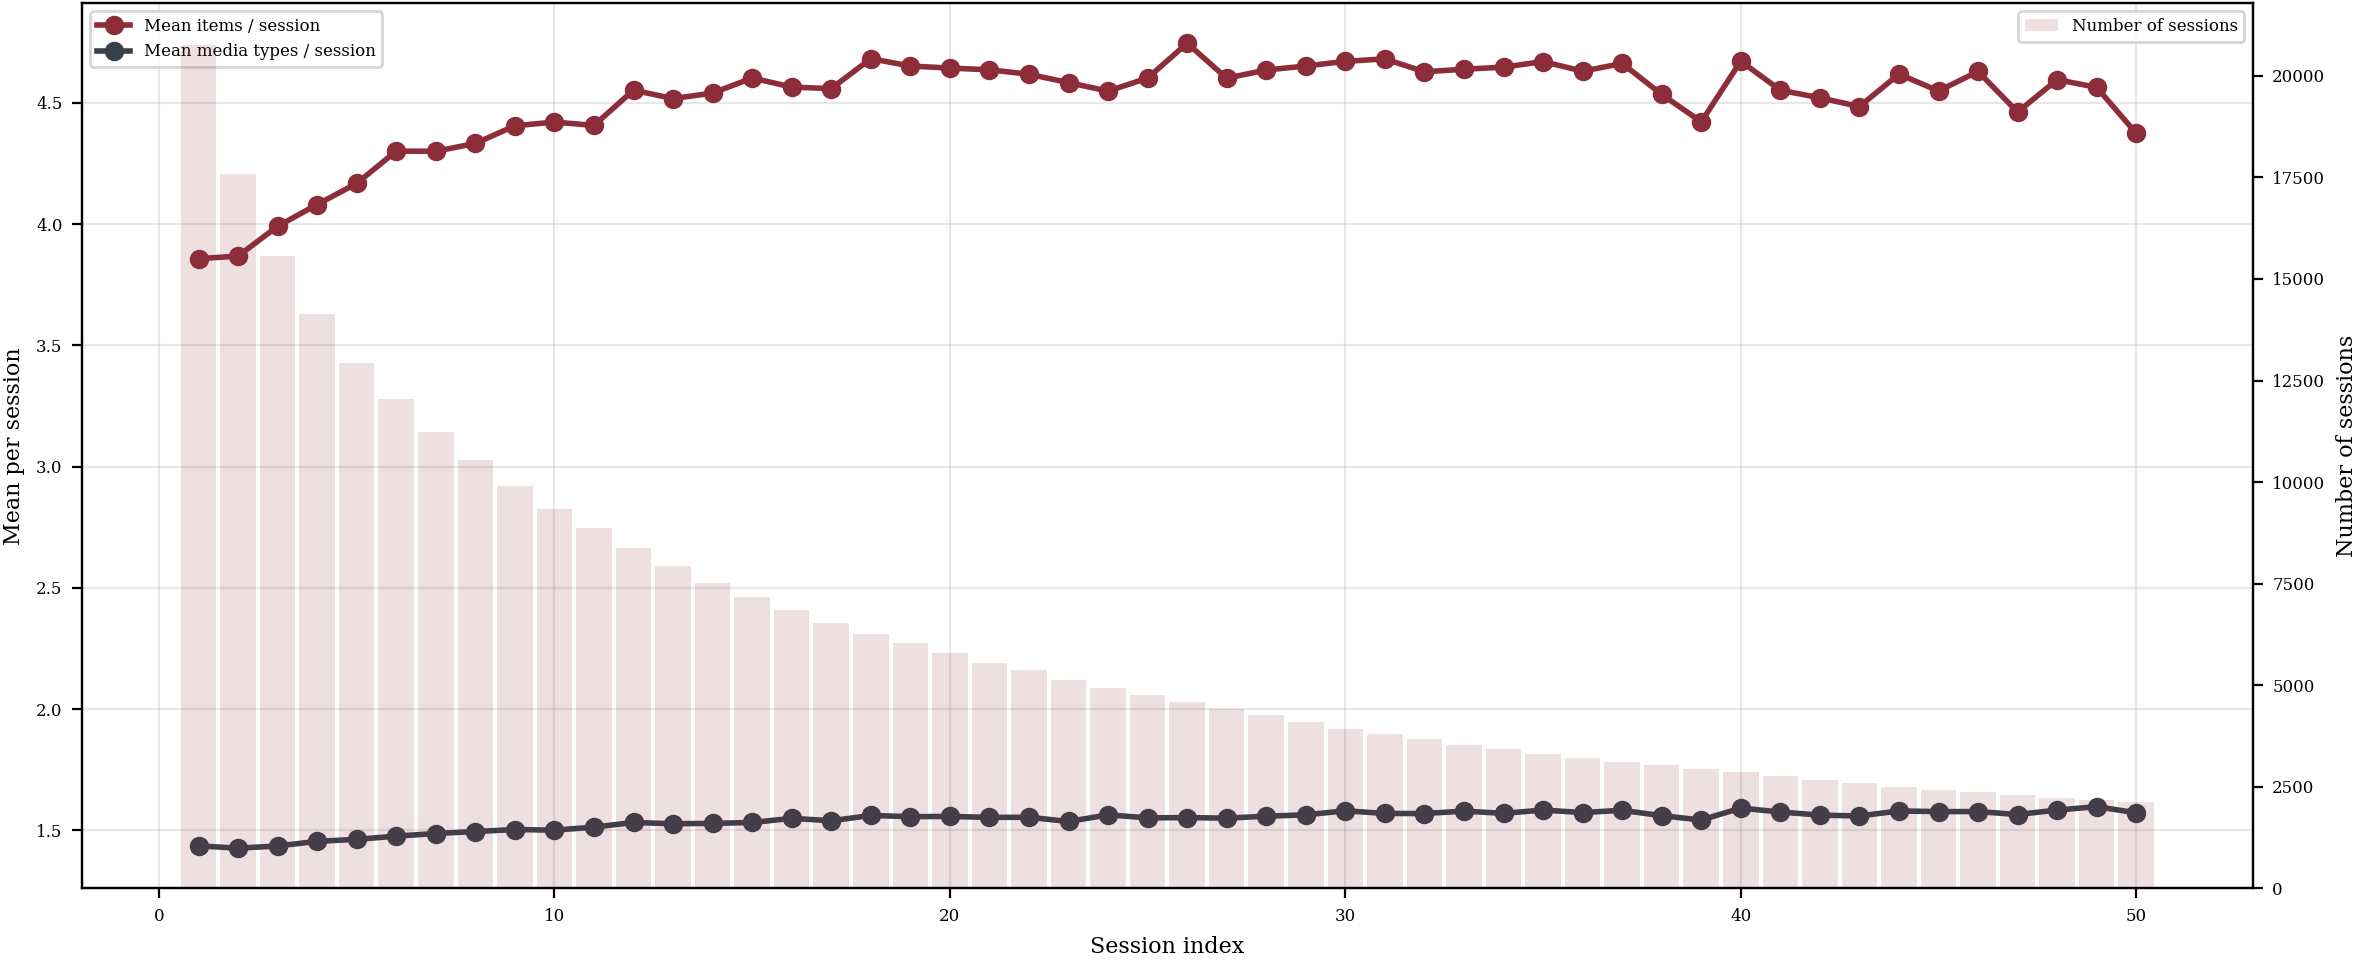

In [14]:
d = df_session_index_table.sort_values("session_index").copy()
x = d["session_index"]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(x, d["mean_items"], marker="o", linewidth=2, label="Mean items / session")
ax.plot(x, d["mean_media_types"], marker="o", linewidth=2, label="Mean media types / session")

ax.set_xlabel("Session index")
ax.set_ylabel("Mean per session")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

# nummer of sessions
ax2 = ax.twinx()
ax2.bar(x, d["n_sessions"], alpha=0.15, width=0.9, label="Number of sessions")
ax2.set_ylabel("Number of sessions")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


Mean items per session show a small gradual increase in the early sessions and then remain roughly constant afterward. Mean media types per session are nearly constant throughout, so overall there’s no meaningful variance or clear change over session index

We can see that the number of distinct media types borrowed within a single session is usually between 1 and 2. This is also reflected in the table above, where the p90 value is 2.
We assume that most sessions contain only one media type. To support this assumption, we look at the following metrics:

In [20]:
observed_sessions = df_sessions[df_sessions["session_index"].between(1, 50)].copy()
total = len(observed_sessions)

counts = {
    "= 1": (observed_sessions["n_media_types"] == 1).sum(),
    "= 2": (observed_sessions["n_media_types"] == 2).sum(),
    "= 3": (observed_sessions["n_media_types"] == 3).sum(),
    "= 4": (observed_sessions["n_media_types"] == 4).sum(),
    ">= 5": (observed_sessions["n_media_types"] >= 5).sum(),
}

output = (
    pd.DataFrame({"amount_of_items_per_session": counts.keys(), "n_sessions": counts.values()})
    .assign(pct=lambda d: 100 * d["n_sessions"] / total)
)

output


,amount_of_items_per_session,n_sessions,pct
0,= 1,196067,63.3518
1,= 2,78774,25.4529
2,= 3,25856,8.3544
3,= 4,6974,2.2534
4,>= 5,1818,0.5874


## Analyzing user behavior in the dominating media type
We now look at the individual session indexes and analyze the dominating media type.

In [21]:
data_frame = df_user_sessions.copy()

session_media = (
    data_frame.groupby([USER_ID_COL, "issue_session", "Medientyp"])
    .size()
    .rename("n")
    .reset_index()
)

session_media = session_media.sort_values([USER_ID_COL, "issue_session", "n"], ascending=[True, True, False])
session_top = session_media.drop_duplicates([USER_ID_COL, "issue_session"]).rename(columns={"Medientyp": "session_media_type"})

session_top["session_index"] = (
    session_top.groupby(USER_ID_COL)["issue_session"]
    .transform(lambda s: pd.factorize(s, sort=True)[0] + 1)
)


First we look if there is a difference in the dominating media type in the first and second loan.

In [25]:
first_two = session_top[session_top["session_index"].isin([1, 2])].copy()

session_type_by_user = (
    first_two.pivot_table(
        index=USER_ID_COL,
        columns="session_index",
        values="session_media_type",
        aggfunc="first"
    )
    .rename(columns={1: "type1", 2: "type2"})
)

session_type_by_user = session_type_by_user.dropna(subset=["type1", "type2"])

repeat_rate = (session_type_by_user["type2"] == session_type_by_user["type1"]).mean()
print(f"P(type2 == type1) = {repeat_rate:.3%}")


P(type2 == type1) = 60.219%


About 60.2% of users with at least two sessions borrow the same media type again in their second session (and ~39.8% switch to a different type).

How is this behavior across media types

/tmp/ipykernel_166525/2772303973.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


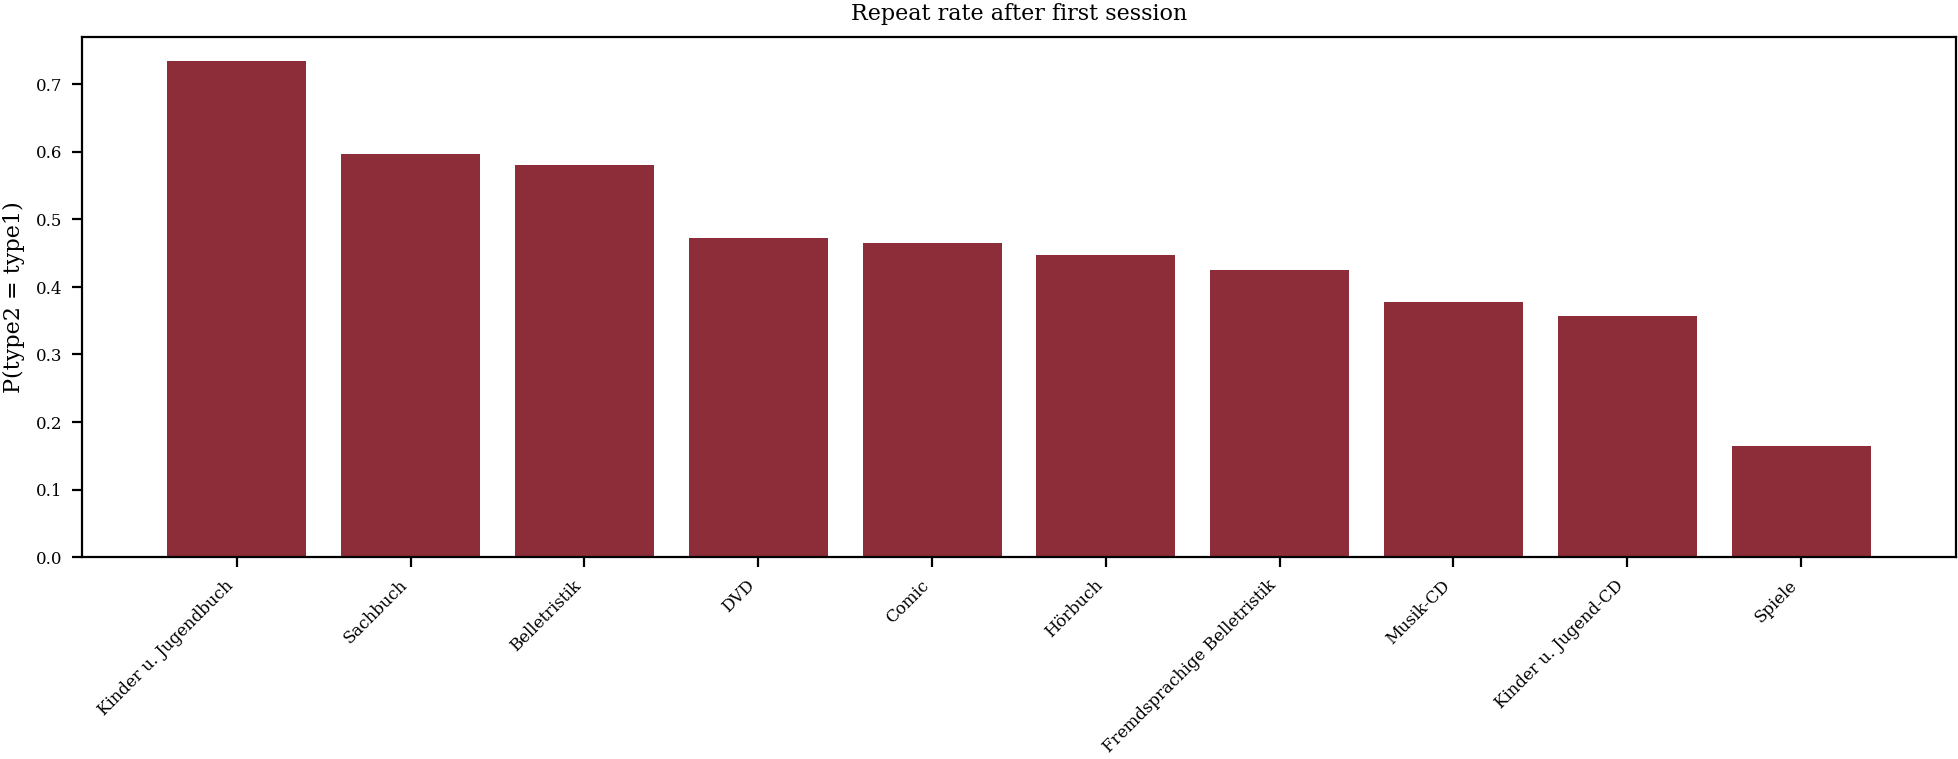

In [27]:
repeat_by_type1 = (
    session_type_by_user.assign(repeat=lambda d: d["type2"] == d["type1"])
    .groupby("type1")["repeat"]
    .agg(rate="mean", n="size")
    .reset_index()
    .sort_values("rate", ascending=False)
)

MIN_USERS = 100
plot_df = repeat_by_type1[repeat_by_type1["n"] >= MIN_USERS].copy()
plt.figure(figsize=(10,4))
plt.bar(plot_df["type1"], plot_df["rate"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("P(type2 = type1)")
plt.title(f"Repeat rate after first session")
plt.tight_layout()
plt.show()


Repeat rates vary a lot by the media type of the first session: Kinder u. Jugendbuch is highest, followed by Sachbuch and Belletristik. Most other types sit around 0.35–0.47, and Spiele has the lowest repeat rate (≈0.16).

One interpretation is that users who come to the library for books are less likely to switch media types in their next session

## How do users change their behavior regarding media types?

This looks interesting, but how do users switch? We can visualize this in a heatmap:

On the x-Axis we see the dominant media type in session 2 and on the y-axis we see the dominant media type in session 1. Each cell describes the probability that the user changes form y to x

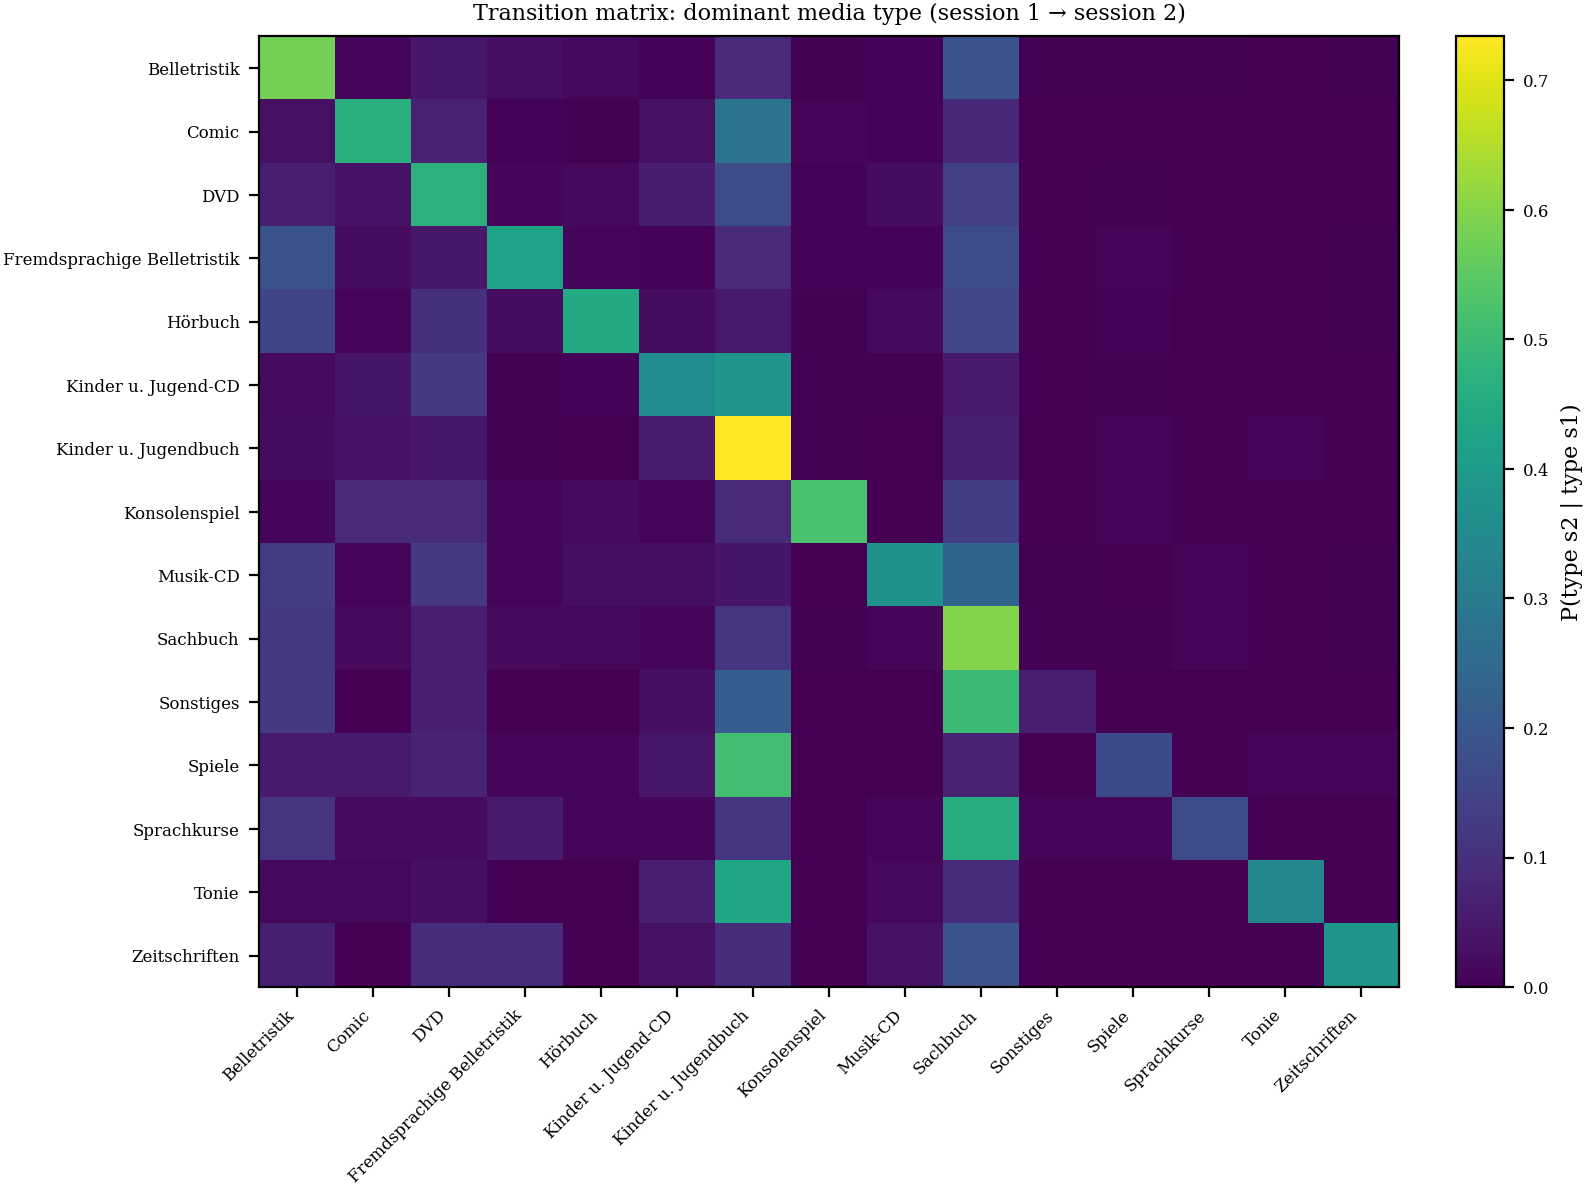

In [30]:
trans_counts = pd.crosstab(session_type_by_user["type1"], session_type_by_user["type2"])
trans_prob = trans_counts.div(trans_counts.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

im = ax.imshow(trans_prob.values, aspect="auto")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("P(type s2 | type s1)")

ax.set_xticks(range(trans_prob.shape[1]))
ax.set_xticklabels(trans_prob.columns, rotation=45, ha="right")
ax.set_yticks(range(trans_prob.shape[0]))
ax.set_yticklabels(trans_prob.index)

ax.set_title("Transition matrix: dominant media type (session 1 → session 2)")
plt.show()

The heatmap shows the conditional probability P(type s2 ∣ type s1): The strong diagonal indicates that many users repeat the same media type in their second session, while a few brighter off-diagonal cells highlight common switches between specific types.

## How do users change their behavior regarding media types over time?
We look at the repeat rate between time steps (k → k + 1)

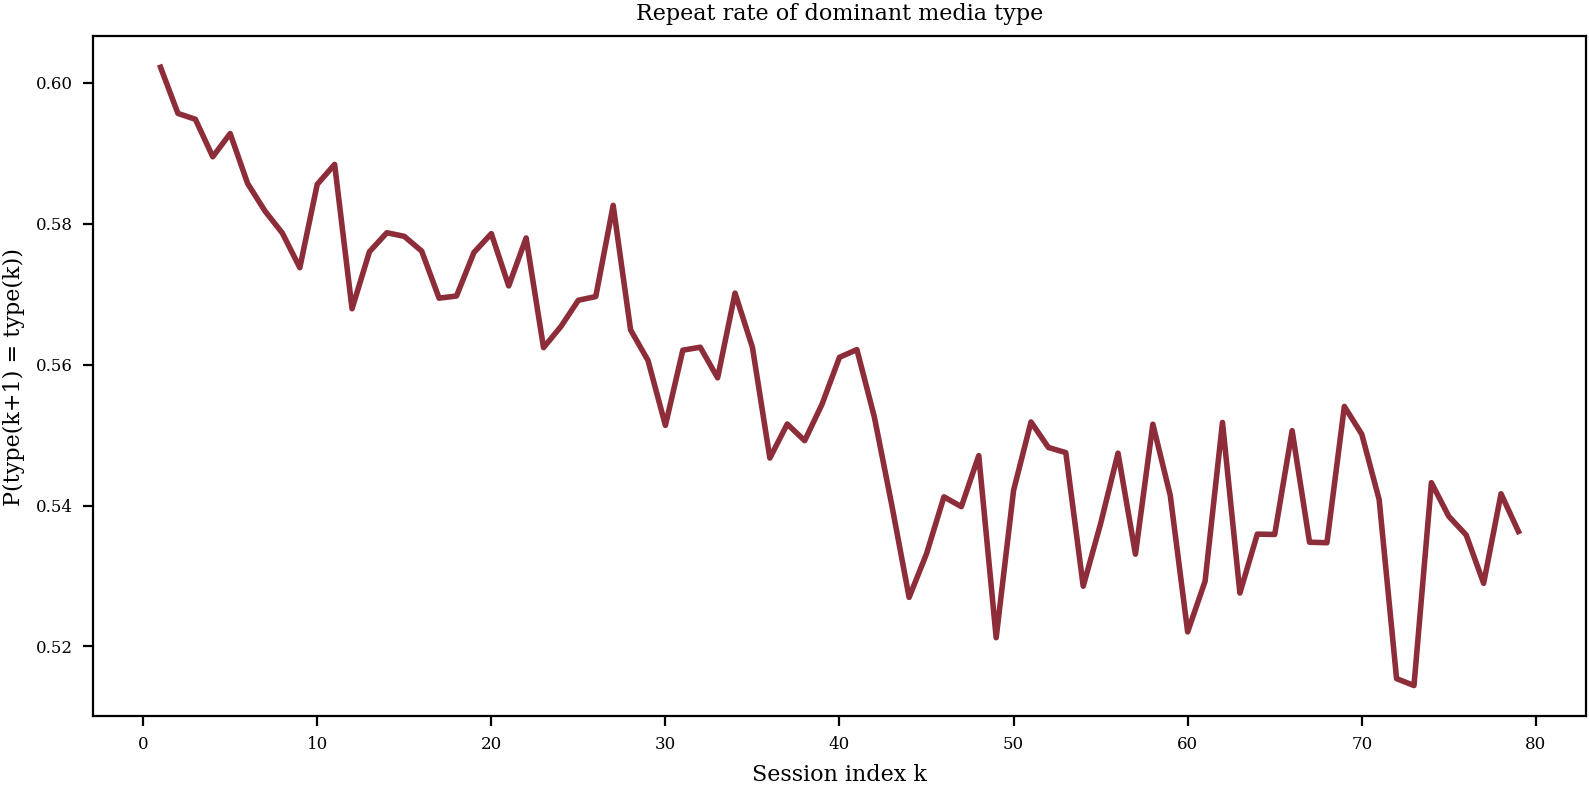

In [35]:
data_frame = df_user_sessions.copy()
data_frame["issue_session"] = pd.to_datetime(data_frame[ISSUE_COL]).dt.floor("D")

# dominant Medientyp pro (User, Session)
session_media = (
    data_frame.groupby([USER_ID_COL, "issue_session", "Medientyp"])
    .size()
    .rename("n")
    .reset_index()
    .sort_values([USER_ID_COL, "issue_session", "n"], ascending=[True, True, False])
)

session_top = (
    session_media.drop_duplicates([USER_ID_COL, "issue_session"])
    .rename(columns={"Medientyp": "session_media_type"})
    [[USER_ID_COL, "issue_session", "session_media_type"]]
)

# session_index pro User
session_top["session_index"] = (
    session_top.groupby(USER_ID_COL)["issue_session"]
    .transform(lambda s: pd.factorize(s, sort=True)[0] + 1)
)

# next type + repeat flag
session_top = session_top.sort_values([USER_ID_COL, "session_index"])
session_top["next_type"] = session_top.groupby(USER_ID_COL)["session_media_type"].shift(-1)
session_top["repeat_next"] = (session_top["next_type"] == session_top["session_media_type"])

# Repeat-Rate pro k (k -> k+1)
curve = (
    session_top.dropna(subset=["next_type"])
    .groupby("session_index")["repeat_next"]
    .agg(rate="mean", n_obs="size")
    .reset_index()
)

# optional: nur stabile Punkte
MIN_OBS = 1000
curve_f = curve[curve["n_obs"] >= MIN_OBS].copy()

plt.figure(figsize=(8,4))
plt.plot(curve_f["session_index"], curve_f["rate"], linewidth=2)
plt.xlabel("Session index k")
plt.ylabel("P(type(k+1) = type(k))")
plt.title(f"Repeat rate of dominant media type")
plt.show()


The repeat probability starts around 60% for early sessions and then gradually declines with increasing session count (with some noise later)
This could mean that users become slightly more likely to switch dominant media type as they accumulate more sessions.

Important note: The change is modest and still indicates that repeating the same type remains the majority behavior

How likely is a user to stick with the first (dominant) media type they borrowed in their first session?


/tmp/ipykernel_166525/2528840721.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


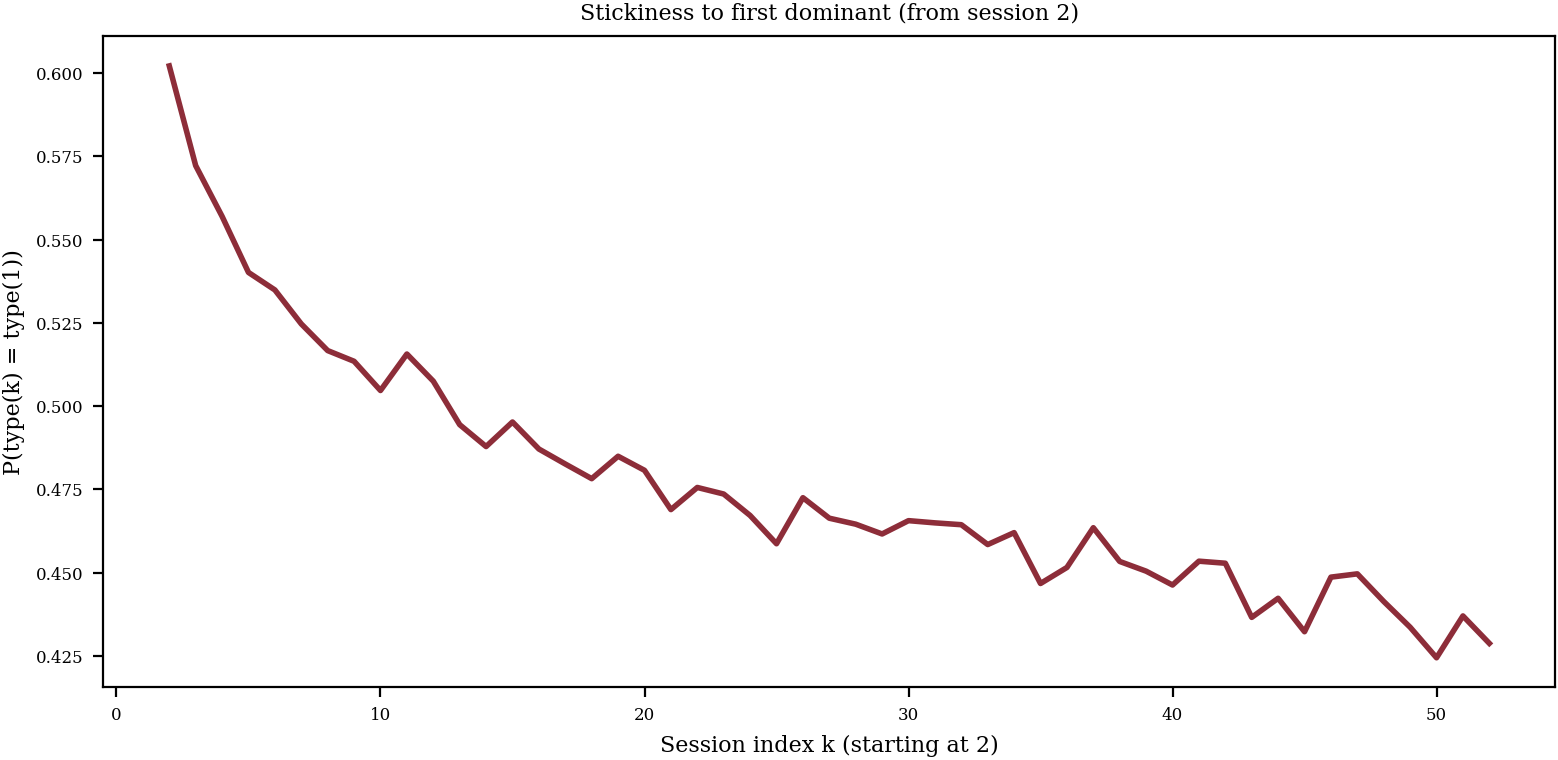

In [37]:
type1 = (
    session_top[session_top["session_index"] == 1]
    .set_index(USER_ID_COL)["session_media_type"]
)

tmp = session_top.join(type1.rename("type1"), on=USER_ID_COL)
tmp["same_as_type1"] = (tmp["session_media_type"] == tmp["type1"])

curve1k = (
    tmp.groupby("session_index")["same_as_type1"]
    .agg(rate="mean", n_obs="size")
    .reset_index()
)

MIN_OBS = 2000
curve1k_f = curve1k[curve1k["n_obs"] >= MIN_OBS].copy()
curve_plot = curve1k_f[curve1k_f["session_index"] >= 2].copy()

plt.figure(figsize=(8,4))
plt.plot(curve_plot["session_index"], curve_plot["rate"], linewidth=2)
plt.xlabel("Session index k (starting at 2)")
plt.ylabel("P(type(k) = type(1))")
plt.title("Stickiness to first dominant (from session 2)")
plt.tight_layout()
plt.show()


The curve shows the probability that a user’s dominant media type in session k is still the same as in their first session, and it declines steadily as k increases. This suggests users gradually diversify away from their initial “dominant” media type: about ~60% match in session 2, falling to roughly ~43–47% by later sessions.